In [1]:
%load_ext rpy2.ipython

###cut a contig at location of small internal peak, and rearrange:

In [9]:
%%R

sip_cut_location=function(coverage_file){
    coverage<-read.table(coverage_file, sep="\t")
    start<-1
    end<-nrow(coverage)
    stddev<-sd(coverage$V3)
    max_spot<-coverage$V2[mean(which(coverage$V3==max(coverage$V3)))]
    cut_spot<-max_spot
    #cut_spot<-paste("'contig_1:",1,"-",max_spot,"'",sep="")
    return(cut_spot)
    }

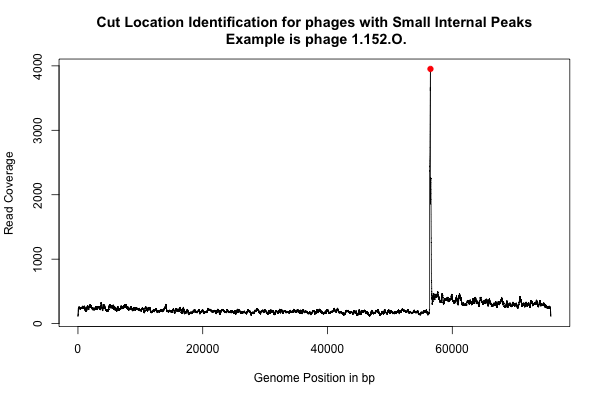

In [46]:
%%R -w=600 -h=400
#test function
#virus with known to have small internal peak in coverage file:
phage<-"1.152.O."
coverage_file=paste("./genomecoverage/step1contig1/",phage,"step1.contig1.genomecoverage.txt", sep="")

cut_spot=sip_cut_location(coverage_file)
cov=read.table(coverage_file, sep="\t")
with(cov, plot(V2, V3, type="l", main=paste("Cut Location Identification for phages with Small Internal Peaks\n Example is phage",phage,sep=" "),xlab="Genome Position in bp",ylab="Read Coverage"))
with(cov, points(cut_spot, V3[cut_spot], col="red", pch=19))


In [88]:

def rearrange_contig_at_cutspot(cut_spot, fasta_file, new_fasta_file):
    '''
    rearranges contig based on a singular break point;
    input is cut_spot location, input contig in fasta format, desired output for new contig
    '''
    new_file=open(new_fasta_file,"w")
    fastafile=fasta_file
    phage=fasta_file.split("/")[-1].replace("step1.contig1.fasta","")
    f=open(fastafile)                                       #open fasta file
    sequence=""
    for row in f:             
        if row.startswith(">"):
            title=row
        else:
            sequence+=row
    sequence=sequence.replace("\n","")
    upstream=sequence[0:int(cut_spot)-1]                    #id sequence before start of small subunit terminase
    downstream=sequence[int(cut_spot)-1:] 
    newseq=downstream+upstream
    new_file.write(">"+phage+"step1.contig1.sip.rearrange\n"+newseq)
    new_file.close()

In [53]:
#test:
%Rpull cut_spot

import os
#os.mkdir("./tests")

rearrange_contig_at_cutspot(cut_spot, "./group5_repeated/1.152.O.step1.contig1.fasta", "./tests/1.152.O.rearrange.fasta")

In [ ]:
#!usr/bin/python
import subprocess

def get_coverage_and_consensus(fasta_file, fastq_file, output_consensus_fasta):
    target_seq=fasta_file
    recruitfile=fastq_file
    recruitfile=fasta_file.replace(".fasta",".cas")
    directed=fasta_file.replace(".fasta","")
    subprocess.call(("clc_mapper -o "+recruitfile+" -p fb ss 100 300 -q "+reads+" -d "+target_seq+" -a local -r ignore").split(" "))
    subprocess.call(("clc_extract_consensus -z none -a "+recruitfile+" -o "+output_consensus_fasta).split(" "))
    subprocess.call(("clc_cas_to_sam -a "+recruitfile+" -o "+directed+".bam").split(" "))
    subprocess.call(("samtools sort "+directed+".bam "+directed+".sorted").split(" "))
    subprocess.call(("samtools index "+directed+".sorted.bam").split(" "))
    subprocess.call(("bedtools genomecov -ibam "+directed+".sorted.bam -d > "+directed+".genomecoverage.txt").split(" "))


target_seq=virus+"step1.contig1.rearrange.fasta"
reads="../"+virus+"*.fastq"
outputfasta=virus+"recruit2.fasta"

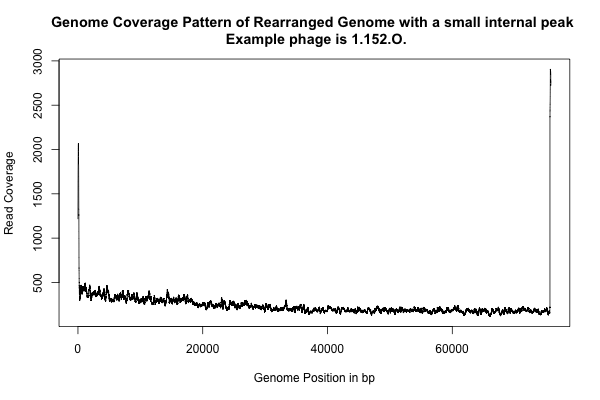

In [56]:
%%R -w 600 -h 400
rearrange_cov_file="./tests/1.152.O.rearrange.genomecoverage.txt"
cov2<-read.table(rearrange_cov_file, sep="\t")
with(cov2, plot(V2, V3, type="l", main="Genome Coverage Pattern of Rearranged Genome with a small internal peak \n Example phage is 1.152.O.", xlab="Genome Position in bp", ylab="Read Coverage"))

###Processing mu-like phage assemblies:

In [60]:
%%R

id_mu_cut_spots=function (coverage_file){
        
    coverage<-read.table(coverage_file, sep="\t")
    difference<-diff(coverage$V3)
    difference<-c(0,difference)

    cov1<-cbind(coverage, difference)
    length<-nrow(cov1)
    mid<-length/2
    stdif<-sd(difference)
    
    cut_spot<-with(cov1[1:mid,], V2[which.max(abs(difference))])
    
    cut_spot2<-with(cov1[mid:length,], V2[which.min(difference)])  
    
    if (cut_spot2>(length-300) & stdif*4<(abs(min(difference[mid:length])))){
        region<-c(cut_spot[1],cut_spot2[1])
    }  else {
        region<-c(cut_spot[1],NA)
    }
    return(region)
    }

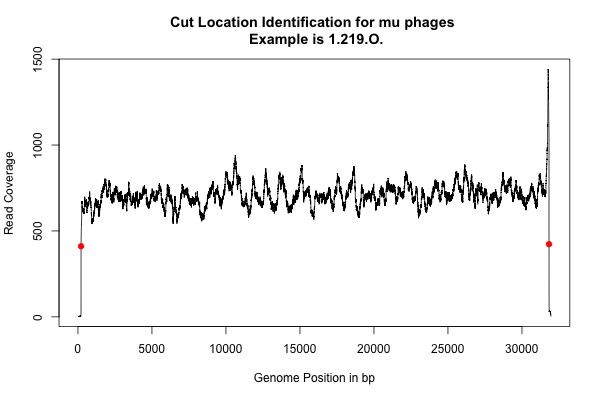

In [61]:
%%R -w 600 -h 400
#Test R function:
#known mu phage: 1.219.O.
coverage_file="./genomecoverage/step1contig1/1.219.O.step1.contig1.genomecoverage.txt"

region=id_mu_cut_spots(coverage_file)

cov<-read.table(coverage_file, sep="\t")
with(cov, plot(V2, V3, type="l",main="Cut Location Identification for mu phages \n Example is 1.219.O.", xlab="Genome Position in bp", ylab="Read Coverage"))
with(cov, points(region, V3[region], pch=19, col="red"))

In [67]:
def trim_mu_contigs(region, input_fasta, rearranged_fasta):
    vec=region.tolist()
    
    f=open(input_fasta)
    sequence=""
    
    for row in f:
        if row.startswith(">"):
            title=row
        else:
            sequence+=row
    sequence=sequence.replace("\n","")
    
    if vec[0]!="NA":
        output=open(rearranged_fasta, "w")
        start=int(vec[0])-1         #(-1 to account for differences in the way that phython and R counts)
    else:
        start=0
        
    if vec[1]!="NA":
        stop=int(vec[1])-1
    else:
        stop=len(sequence)


    target=(sequence[start:stop])
    output.write(title+target)
    output.close()

In [69]:
%Rpull region
trim_mu_contigs(region, "./group17/1.219.O.step1.contig1.fasta","./tests/1.219.O.rearranged.fasta")

In [70]:
!scp ./tests/1.219.O.rearranged.fasta jbrown@eofe4.mit.edu:/nobackup1/jbrown/nahant_phage_reads/tests/

'''
python get_coverage_and_consensus.py 1.219.O.rearranged.fasta ../1.219.O.*.fastq 1.219.O.rearrange_consensus.fasta

'''

1.219.O.rearranged.fasta                      100%   31KB  30.9KB/s   00:00    


'\npython get_coverage_and_consensus.py 1.219.O.rearrange.fasta ../1.219.O.*.fastq 1.219.O.rearrange_consensus.fasta\n\n'

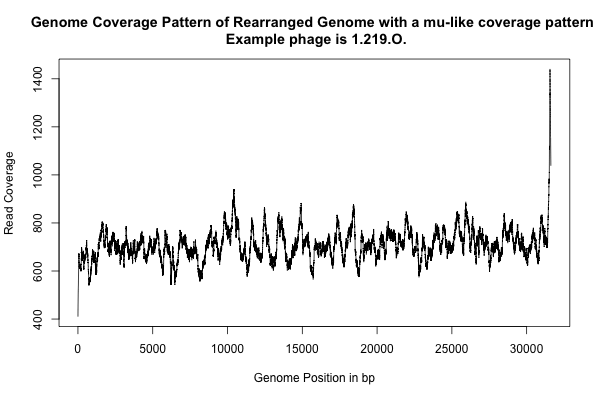

In [75]:
%%R -w 600 -h 400
cov2=read.table("./tests/1.219.O.rearrange_consensus.genomecoverage.txt", sep="\t")
with(cov2, plot(V2, V3, type="l", main="Genome Coverage Pattern of Rearranged Genome with a mu-like coverage pattern \n Example phage is 1.219.O.", xlab="Genome Position in bp", ylab="Read Coverage"))

###ID cut spot of phages with a cos-like pattern:

In [82]:
%%R
###returns one point to cut at, like phages with a short internal peak, 
#so cut them in the same way, using rearrange_contig_at_midpoint.py


find_cos_dip=function(coverage_file, cos_sd_factor=4){
    coverage<-read.table(coverage_file, sep="\t")
       
    length<-nrow(coverage)

    cos_omit_ends_cov<-coverage[(200:(length-200)),]   #excluding larger ends of the contig in this case      
    cos_below_ave<-cos_omit_ends_cov[cos_omit_ends_cov$V3<(mean(coverage$V3)-(sd(coverage$V3)*cos_sd_factor)),]
    
    cos_below_ave$gaps<-c(diff(cos_below_ave$V2),1)
    cos_below_ave_peaks<-cos_below_ave[cos_below_ave$gaps<5,]
    size<-max(cos_below_ave_peaks$V2)-min(cos_below_ave_peaks$V2)
    dip_midpoint<-round(mean(cos_below_ave_peaks$V2))
    cos_split<-dip_midpoint
    return(dip_midpoint)
    }

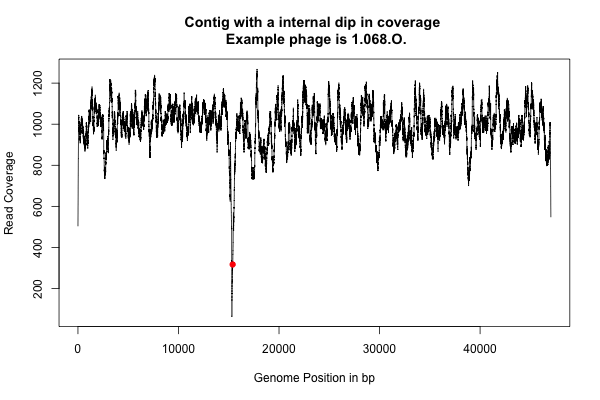

In [97]:
%%R -w 600 -h 400
#test cos dip identification with phage 1.068.O.
coverage_file="./group14/1.068.O.step1.contig1.genomecoverage.txt"

dip_spot=find_cos_dip(coverage_file)
cov=read.table(coverage_file, sep="\t")
with(cov, plot(V2, V3, type="l", main="Contig with a internal dip in coverage \n Example phage is 1.068.O.", xlab="Genome Position in bp", ylab="Read Coverage"))
with(cov, points(dip_spot, V3[dip_spot], col="red",pch=19))

In [90]:
#test rearrangement of phage with a cos dip:
%Rpull dip_spot
rearrange_contig_at_cutspot(dip_spot, "./group14/1.068.O.step1.contig1.fasta", "./tests/1.068.O.rearrange.fasta")

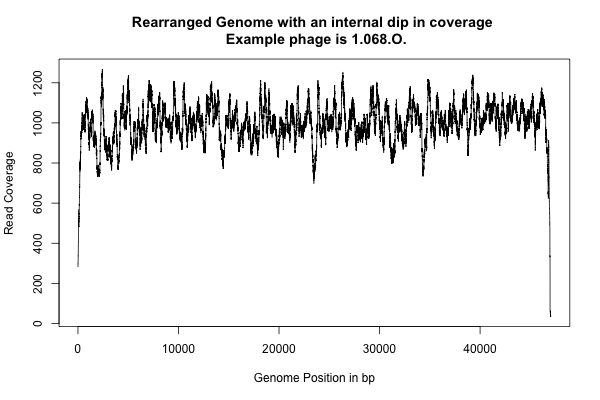

In [96]:
%%R -w 600 -h 400
cov2=read.table("./tests/1.068.O.rearrange_consensus.genomecoverage.txt", sep="\t")
with(cov2, plot(V2, V3, type="l", main="Rearranged Genome with an internal dip in coverage \n Example phage is 1.068.O.", xlab="Genome Position in bp", ylab="Read Coverage"))

###If phages expected to be headful:

In [98]:
import subprocess

def run_prodigal(fasta_file):
    'run prodigal to call proteins on a contig; input is a preliminary assembly of a viral genome'
    suffix=fasta_file.split(".")[-1]
    command="prodigal -i "+fasta_file+" -o "+fasta_file.replace(suffix, ".genes")+" -a "+fasta_file.replace(suffix, "proteins.faa")+" -p meta\n"
    subprocess.call(command.split(" "))
    
def blastp_vs_terminase_db(inputfasta):
    'blast sequence against a database of terminases; input is a file of translated ORFs'
    suffix=inputfasta.split(".")[-1]
    bout1=inputfasta.replace(suffix,"prodprot.vs.lg.terminases.txt")
    blastcommand="blastp -db /nobackup1/jbrown/blast_db/terminase_lg_subunit.fasta -query "+inputfasta+" -num_descriptions 1 -evalue 0.00001 -outfmt 6 -out "+bout1
    subprocess.call(command.split(" "))

In [129]:
#for headful phages, begin genome one ORF upstream of the large subunit terminase (often the small subunit terminase):
from Bio.Seq import Seq
import os.path
import re

def dict_from_prodigal(prodigal):
    'create dictionary of ORFs from prodigal output; input prodigal file'
    gene_tbl=open(prodigal).readlines()     #open prodigal gene table for phage genome
    loc=[]
    nam=[]
    for line in gene_tbl[2:]:
        here=line.split()
        if here[0]=="CDS":
            loc.append(here[1])
        else:
            info=here[0].split(";")
            there=info[0].split("=")
            if len(there)==3:
                nam.append("contig_"+there[2])
    dict1=dict(zip(nam,loc))  
    return(dict1)

def id_terminase_location(blastfile):
    '''
    input is a -m 8 formatted result of a blast of translated orfs against a terminase database;
    and a dictionary of ORF locations created via dict_from_prodigal function
    '''
    blast=open(blastfile).readlines() 
    terminase_hits=[]
    e_values=[]
    best_evalue=1
    best_e_line=""
    for line in blast:
        if line.split("\t")[0] not in terminase_hits:
            terminase_hits.append(line.split("\t")[0])
            e_values.append(line.split("\t")[10])  

        if float(line.split("\t")[10])<best_evalue:
            best_evalue=float(line.split("\t")[10])
            orf=line.split("\t")[0]
    return orf

def adjust_contig_by_terminase(terminase_orf, dict1, genomic_fasta, outfile):
    '''
    function adjusts a complete phage genomic contig so that it's start location is one gene upstream
    of the large subunit terminase.  Inputs are the terminase location, determined via the function
    id_terminase_location and a dict of orf locations calculated using dict_from_prodigal.
    '''
    orf=terminase_orf
    value=dict1[orf]
    phage=genomic_fasta.split("/")[-1]   #this label is unique to the Nahant Phage Collection titles
    phage=re.search(r"(1|2){1}\.(\d){3}\.(A|B|O){1}\.", phage).group()
    
    if value.startswith("complement"): #determine orientation of orf and
            adjust=orf.split("_")                                           #identification of start of gene upstream of terminase large subunit
            orientation="reverse"
            key2=adjust[0]+"_"+adjust[1]+"_"+str(int(adjust[2])+1)   #"upstream" gene is one ORF behind terminase
            value2=dict1.get(key2,0)
            if dict1.get(key2,0)!=0:                                           

                vec1=value2.split("(")
                vec2=vec1[1].split("..")
                start=vec2[1]
                stop=vec2[0]

            else:
                print("end of contig reverse")
                key2=adjust[0]+"_"+adjust[1]+"_1"
                orientation="reverse"
                value2=dict1.get(key2,"end of contig")
                vec1=value2.split("(")
                vec2=vec1[1].split("..")
                start=vec2[0]
                stop=vec2[1]

    else:
        #terminase orf is on the leading strand
        adjust=orf.split("_")
        key2=adjust[0]+"_"+adjust[1]+"_"+str(int(adjust[2])-1)  #"upstream" gene is one ORF before terminase
        orientation="forward"
        if dict1.get(key2,0)!=0:
            value2=dict1.get(key2,"end of contig")
            vec2=value2.split("..")
            start=vec2[0]
            stop=vec2[1]      
        else:
            #orf is at the end of the contig
            orf_num=len(dict1)
            key2=adjust[0]+"_"+adjust[1]+"_"+str(orf_num)
            if ">" in dict1.get(key2,0):
                key2=adjust[0]+"_"+adjust[1]+"_"+str(orf_num-1)
            value2=dict1.get(key2, 0)
            vec2=value2.split("..")
            start=vec2[0]
            stop=vec2[1]
    start=start.replace(">","").replace(")","").replace("<","")
    stop=stop.replace(">","").replace(")","").replace("<","")

    fastafile=genomic_fasta
    f=open(fastafile)                                       #open fasta file
    sequence=""
    for row in f:                           #define title and sequences
        if row.startswith(">"):
            title=row
        else:
            sequence+=row
    sequence=sequence.replace("\n","")
    outfile=open(outfile,"w")
    upstream=sequence[0:int(start)-1]                    #id sequence before start of small subunit terminase
    downstream=sequence[int(start)-1:]                   #id sequence after start of small subunit terminase 
    rearrange=downstream+upstream                        #re-arrange contigs so that small subunit terminase start is at end of contig

    if orientation=="reverse":                           #reverse-complement the genome if terminase gene is in reverse orientation
        seq=Seq(rearrange)
        out_seq=seq.reverse_complement()
        outfile.write(">"+phage+"\n"+str(out_seq))

    else:
        outfile.write(">"+phage+"\n"+rearrange)
    
    outfile.close()
    


In [135]:
#testing headful method using 1.104.O.
dict1=dict_from_prodigal("./group4/1.251.O.genes")
terminase=id_terminase_location("./group4/1.251.O.prodprot.vs.lg.terminases.txt")
adjust_contig_by_terminase(terminase, dict1, "./group4/1.251.O.step1.contig1.fasta", "./tests/1.251.O.rearrange.fasta")

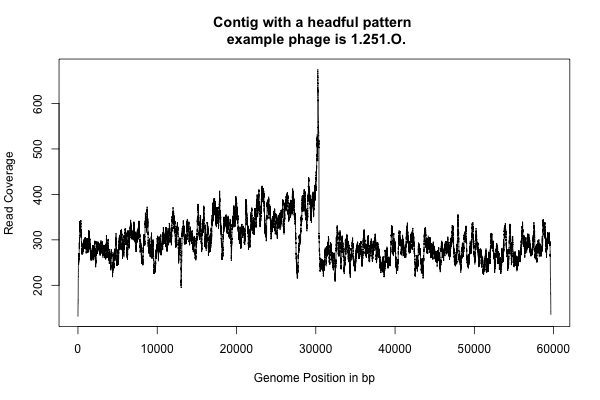

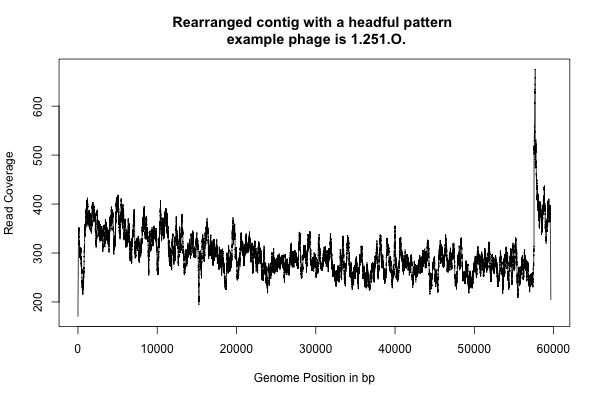

In [138]:
%%R -h 400 -w 600
cov<-read.table("./genomecoverage/step1contig1/1.251.O.step1.contig1.genomecoverage.txt")
with(cov, plot(V2, V3, type="l", main="Contig with a headful pattern \n example phage is 1.251.O.", xlab="Genome Position in bp", ylab="Read Coverage"))

cov2<-read.table("./tests/1.251.O.rearrange_consensus.genomecoverage.txt")
with(cov2, plot(V2, V3, type="l", main="Rearranged contig with a headful pattern \n example phage is 1.251.O.", xlab="Genome Position in bp", ylab="Read Coverage"))

In [144]:
##creating dotplots via mummer:
#input:
from pyfaidx import Fasta

def get_contig_len(fasta):
    f=Fasta(fasta)
    length=len(str(f[0]))

def create_dot_plot(fasta1, fasta2, result_prefix):
    to_run="mummer -mum -b -c "+fasta1+" "+fasta2
    out1name=result_prefix+".mum"
    output1=open(out1name, "w")
    #subprocess.call(to_run.split(" "), stdout=output1)
    output1.close()
    
    f1_len=get_contig_len(fasta1)
    f2_len=get_contig_len(fasta2)
    torun2='mummerplot -x "[0,%s]" -y "[0,%s]" -postscript -p %s %s' %f1_len, f2_len, result_prefix, out1name
    subprocess.call(torun2.split(" "))